# About The Dataset

The data consists of the estimation of obesity levels in people from the countries of Mexico, Peru and Colombia, with ages between 14 and 61 and diverse eating habits and physical condition; data was collected using a web platform with a survey where anonymous users answered each question, then the information was processed obtaining 17 attributes and 2111 records. The attributes related to eating habits are:
- Frequent Consumption of High Caloric Foods (FAVC)
- Frequency of Consumption of Vegetables (FCVC)
- Number of Main Meals (NCP)
- Consumption of Food Between Meals (CAEC)
- Consumption of Water (CH2O)
- Consumption of Alcohol (CALC)

The attributes related with the physical condition are:
- Calories Consumption Monitoring (SCC)
- Physical Activity Frequency (FAF)
- Time Using Technology Devices (TUE)
- Transportation Used (MTRANS)

Variables obtained:
- Gender
- Age
- Height
- Weight

NObesity values are:
- Underweight: Less than 18.5
- Normal: 18.5 to 24.9
- Overweight: 25.0 to 29.9
- Obesity I: 30.0 to 34.9
- Obesity II: 35.0 to 39.9
- Obesitt III: Higher than 40

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import optuna
from hyperopt import fmin, tpe, hp
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import category_encoders as ce

In [2]:
file_path_train = r'C:\Users\mirko\Desktop\train.csv'
file_path_test = r'C:\Users\mirko\Desktop\test.csv'
train = pd.read_csv(file_path_train)
test = pd.read_csv(file_path_test)

In [3]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
test.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [5]:
train.shape

(20758, 18)

In [6]:
test.shape

(13840, 17)

In [7]:
description = pd.DataFrame(index = list(train))
description['type'] = train.dtypes
description['count'] = train.count()
description['nunique'] = train.nunique()
description['null'] = train.isnull().sum()
description['min'] = train.min()
description['max'] = train.max()
description

,type,count,nunique,null,min,max
id,int64,20758,20758,0,0,20757
Gender,object,20758,2,0,Female,Male
Age,float64,20758,1703,0,14.0,61.0
Height,float64,20758,1833,0,1.45,1.975663
Weight,float64,20758,1979,0,39.0,165.057269
family_history_with_overweight,object,20758,2,0,no,yes
FAVC,object,20758,2,0,no,yes
FCVC,float64,20758,934,0,1.0,3.0
NCP,float64,20758,689,0,1.0,4.0
CAEC,object,20758,4,0,Always,no


In [8]:
train_copy = train.copy()
train_copy_noid = train_copy.drop('id', axis=1)
numerical_features= train_copy_noid._get_numeric_data().columns
numerical_features

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')

In [9]:
categorical_features = list(test.select_dtypes('object'))
categorical_features

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS']

In [10]:
categorical_features_train = list(train.select_dtypes('object'))
categorical_features_train

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'NObeyesdad']

# Visualizing The Data

Now I'm going to plot the countplots for the categorical features, as well as the countplot for the target variable, to identify potential class imbalance. 
I'm also going to plot the frequency distributions of our numerical variables, to see if we need to scale them.
This usually gives me a good idea for feature engineering too.

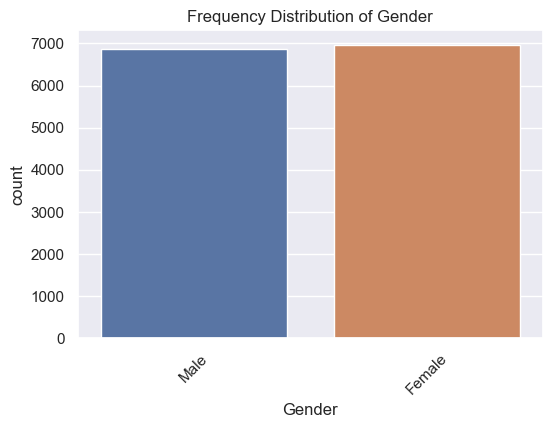

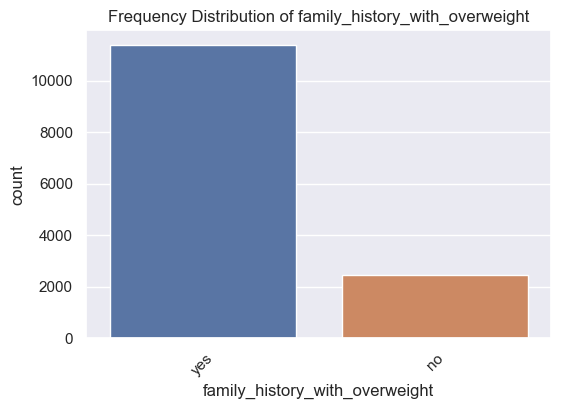

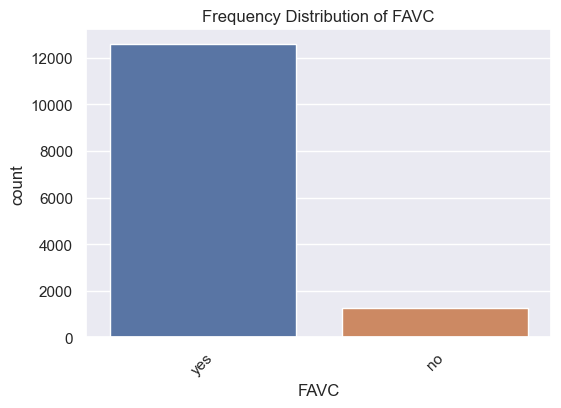

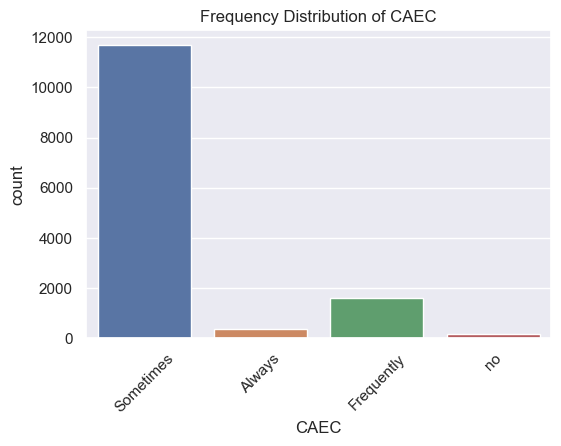

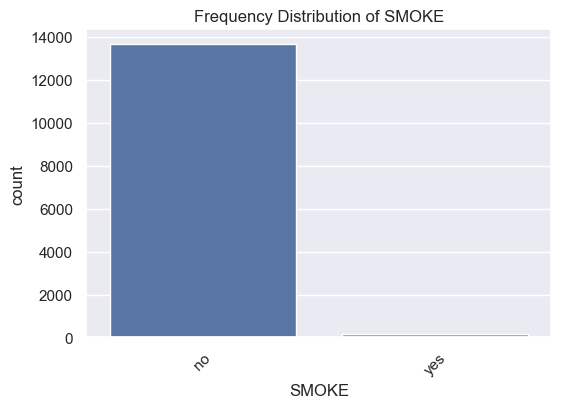

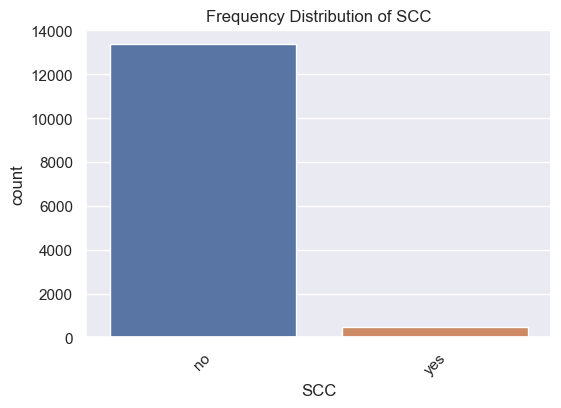

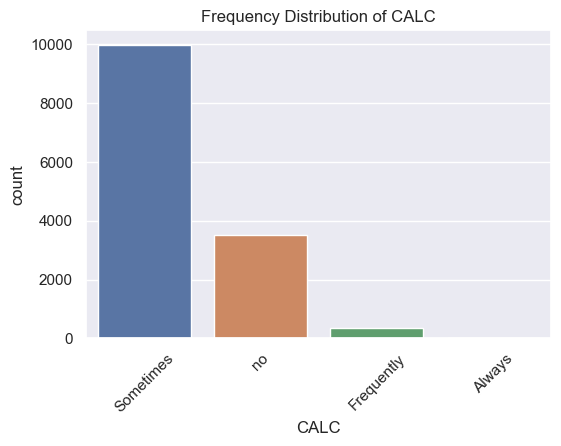

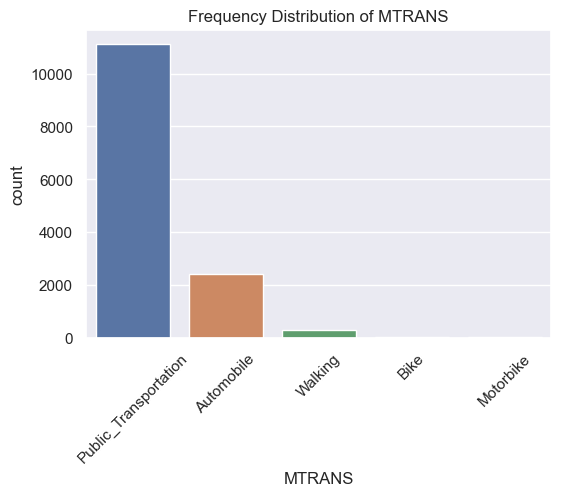

In [11]:
sns.set(style='darkgrid')
for column in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=column, data=test)
    plt.title(f'Frequency Distribution of {column}')
    plt.xticks(rotation=45)
    plt.show()

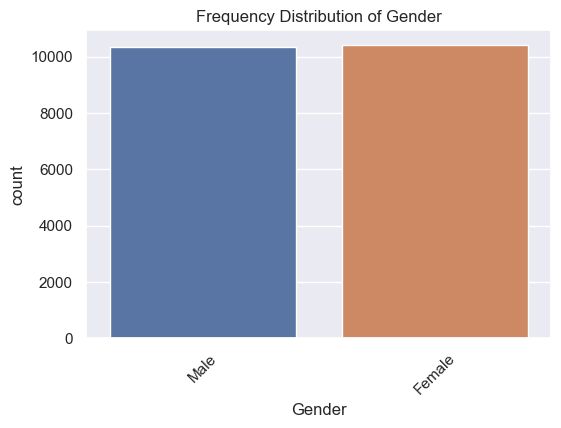

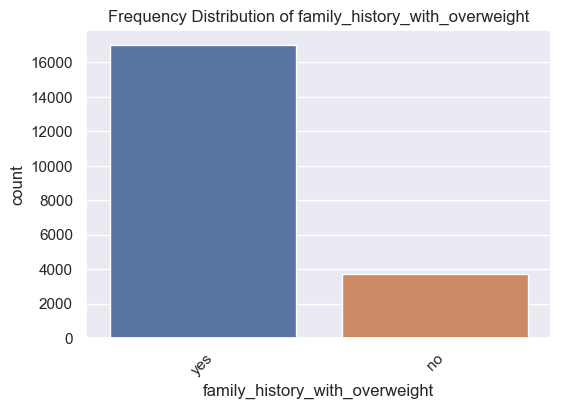

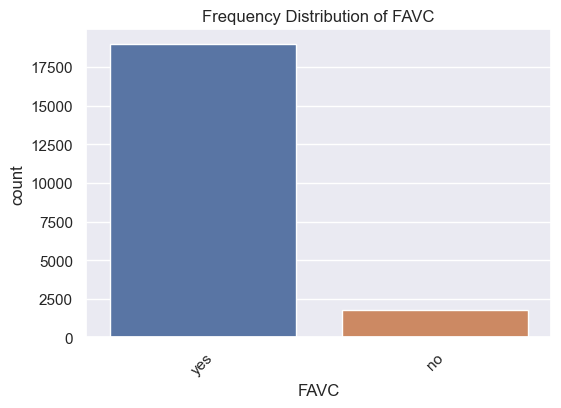

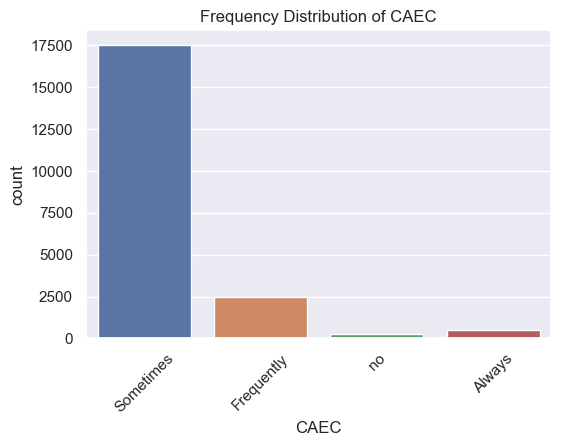

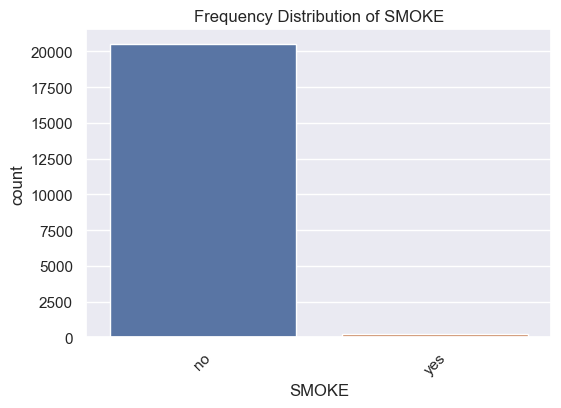

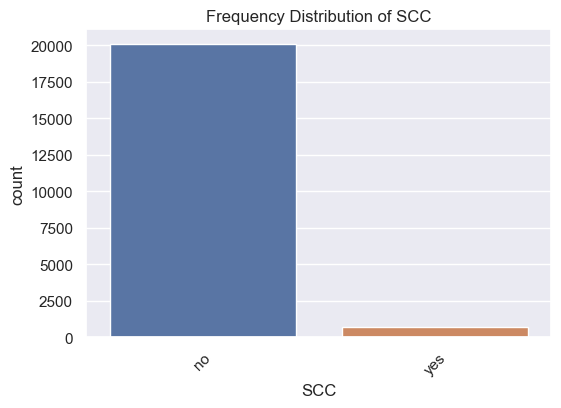

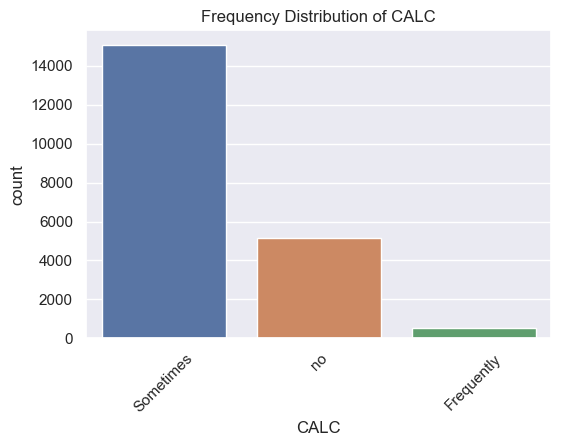

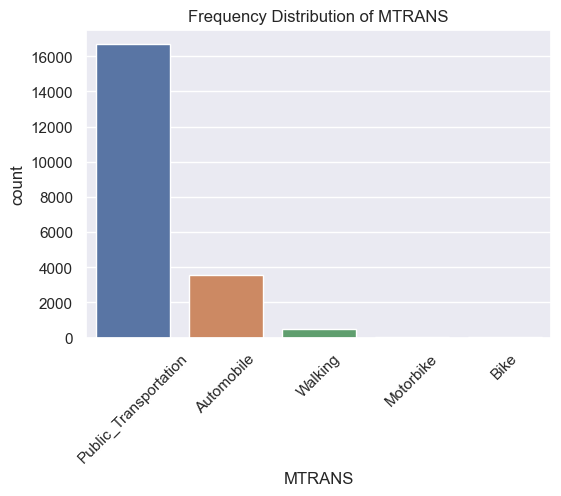

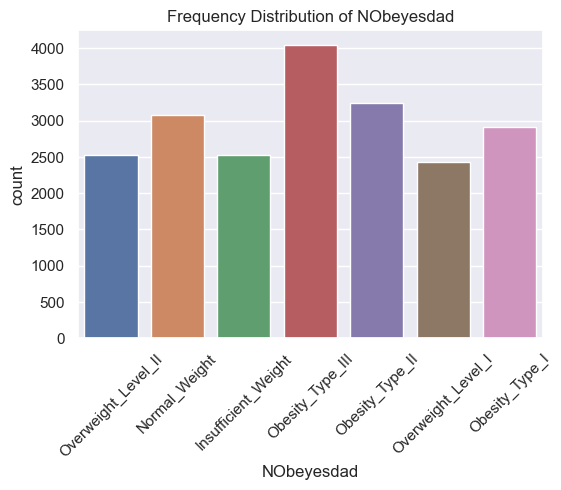

In [12]:
sns.set(style='darkgrid')
for column in categorical_features_train:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=column, data=train)
    plt.title(f'Frequency Distribution of {column}')
    plt.xticks(rotation=45)
    plt.show()

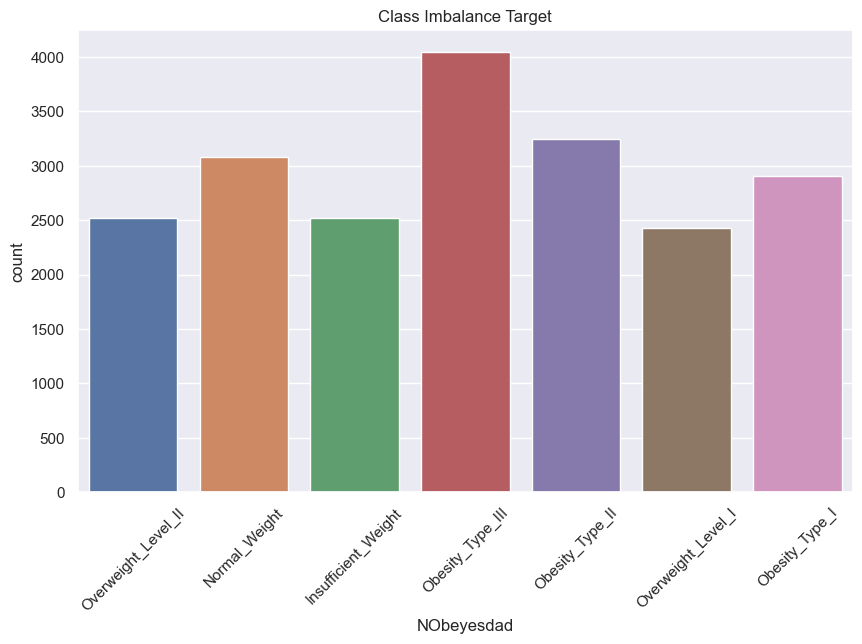

In [13]:
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='NObeyesdad', data=train)
plt.title('Class Imbalance Target')
plt.xticks(rotation=45)
plt.show()

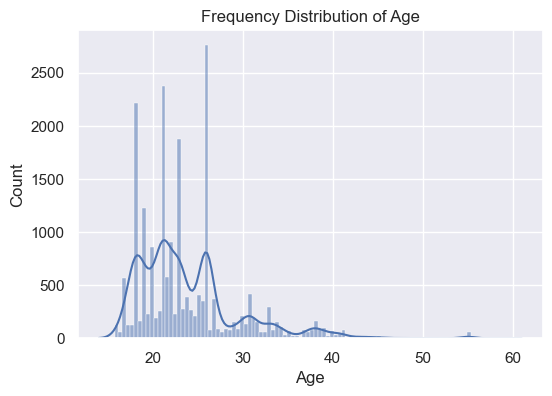

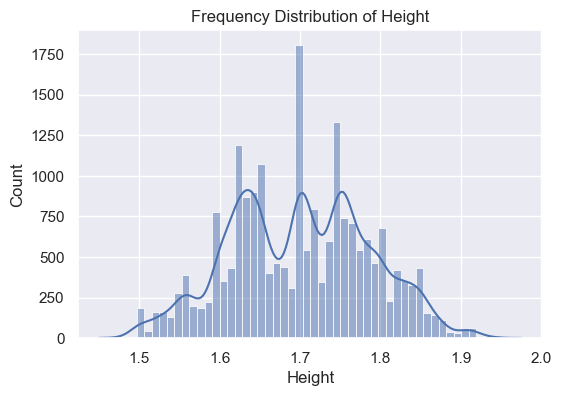

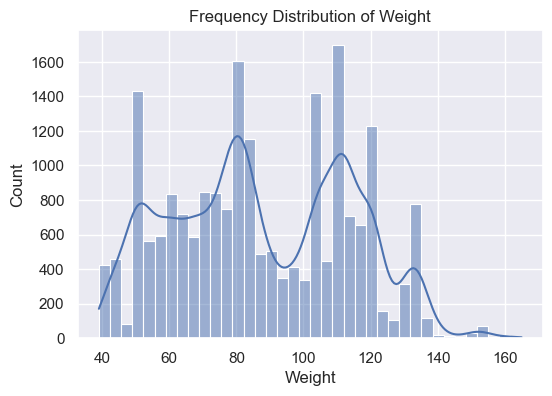

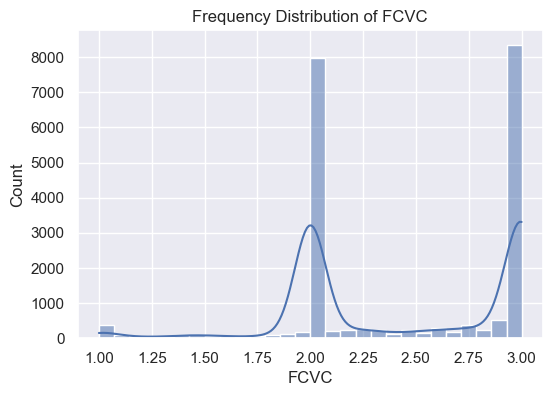

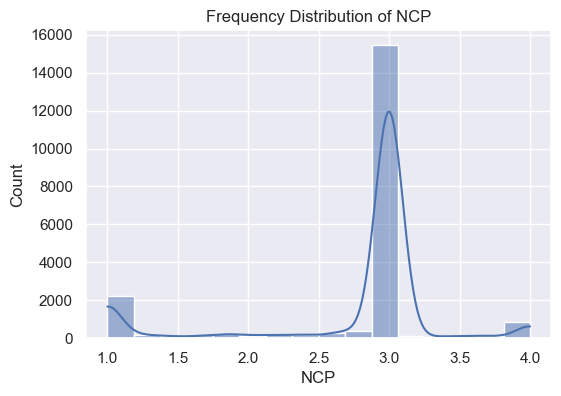

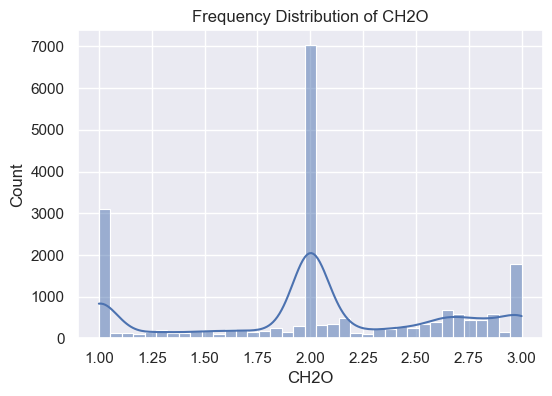

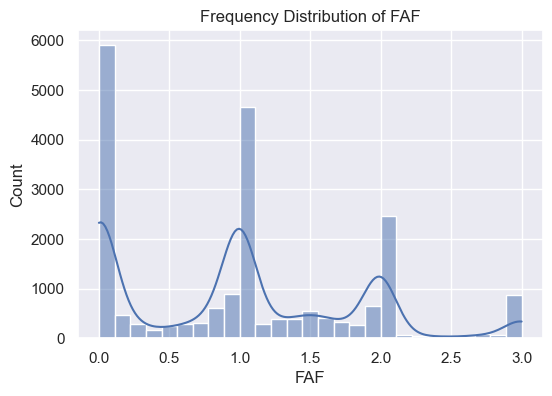

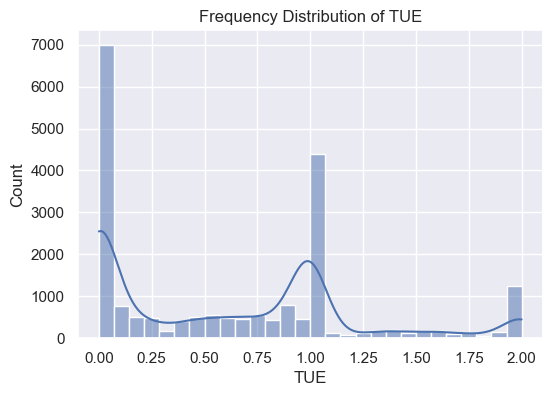

In [14]:
sns.set(style='darkgrid')
for column in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(x=column, data=train, kde=True)
    plt.title(f'Frequency Distribution of {column}')
    plt.show()

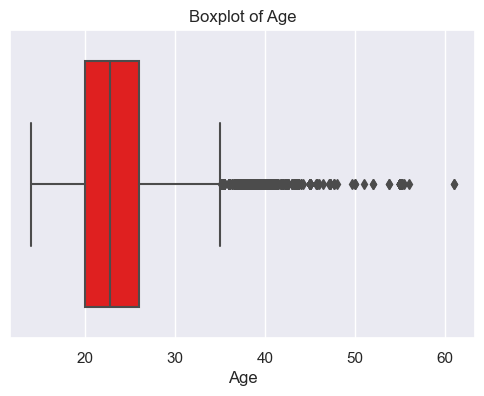

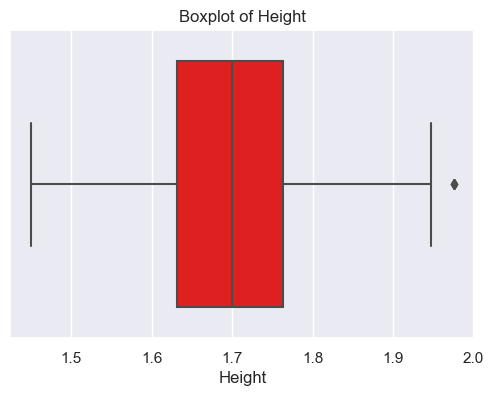

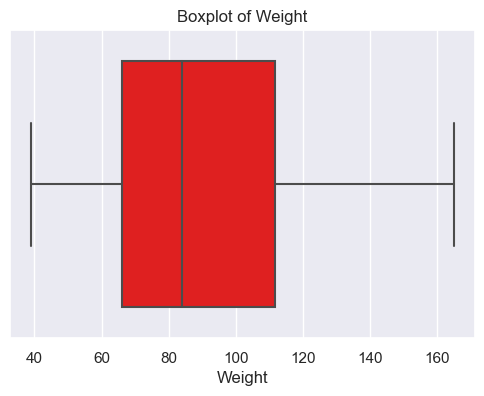

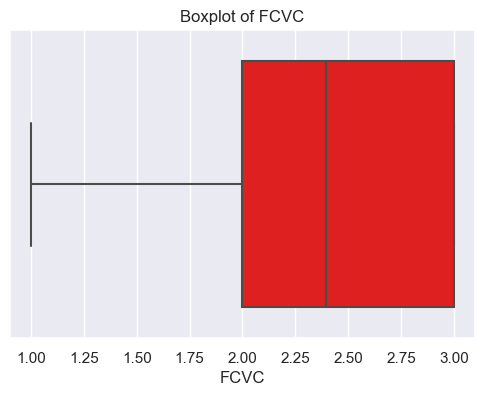

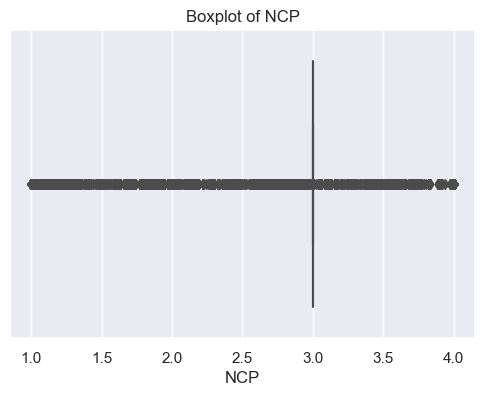

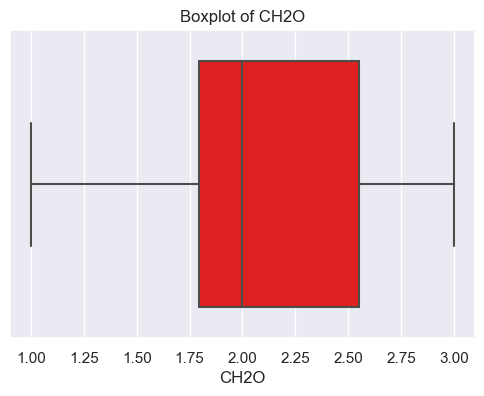

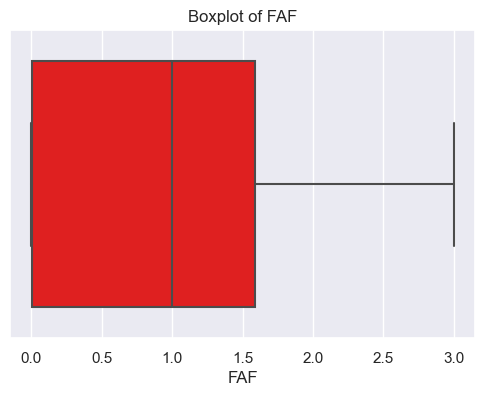

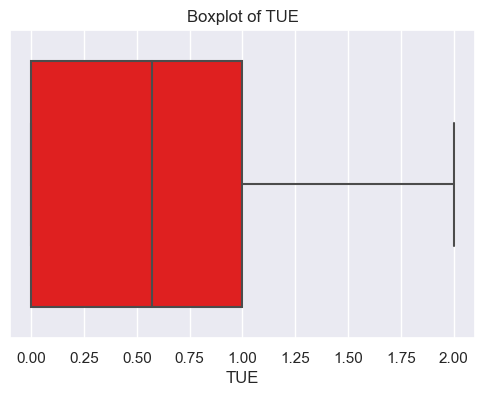

In [15]:
sns.set(style='darkgrid')
for column in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=column, data=train, color='red')
    plt.title(f'Boxplot of {column}')
    plt.show()

# Feature Engineering

In [16]:
train['Age'] = train['Age'].astype(np.uint8)
test['Age'] = test['Age'].astype(np.uint8)

In [17]:
age_bins = [
    (train['Age'] <= 20),
    (train['Age'] > 20) & (train['Age'] <= 28),
    (train['Age'] > 28) & (train['Age'] <= 45),
    (train['Age'] > 45)
]

age_choices = [1, 2, 3, 4]
train['Age_Binned'] = np.select(age_bins, age_choices, default=0)

age_bins = age_bins = [
    (test['Age'] <= 20),
    (test['Age'] > 20) & (test['Age'] <= 28),
    (test['Age'] > 28) & (test['Age'] <= 45),
    (test['Age'] > 45)
]
test['Age_Binned'] = np.select(age_bins, age_choices, default=0)

In [18]:
# train['Height'] = (train['Height'] * 100).astype(np.uint16)
# test['Height'] = (test['Height'] * 100).astype(np.uint16)

In [19]:
height_bins = [
    (train['Height'] <= 1.62),
    (train['Height'] > 1.62) & (train['Height'] <= 1.80),
    (train['Height'] > 1.80)
]

height_choices = [1, 2, 3]
train['Height_Binned'] = np.select(height_bins, height_choices, default=0)

height_bins = [
    (test['Height'] <= 1.62),
    (test['Height'] > 1.62) & (test['Height'] <= 1.80),
    (test['Height'] > 1.80)
]

test['Height_Binned'] = np.select(height_bins, height_choices, default=0)

In [20]:
# height_bins = [
#     (train['Height'] <= 162),
#     (train['Height'] > 162) & (train['Height'] <= 180),
#     (train['Height'] > 180)
# ]

# height_choices = [1, 2, 3]
# train['Height_Binned'] = np.select(height_bins, height_choices, default=0)

# height_bins = [
#     (test['Height'] <= 162),
#     (test['Height'] > 162) & (test['Height'] <= 180),
#     (test['Height'] > 180)
# ]

# test['Height_Binned'] = np.select(height_bins, height_choices, default=0)

In [21]:
# train['TUE'] = (train['TUE'] * 100).astype(np.uint32)
# test['TUE'] = (test['TUE'] * 100).astype(np.uint32)

In [22]:
# train['Weight'] = (train['Weight'] * 10).astype(np.uint32)
# test['Weight'] = (test['Weight'] * 10).astype(np.uint32)

In [23]:
# train['FCVC'] = (train['FCVC'] * 100).astype(np.uint32)
# test['FCVC'] = (test['FCVC'] * 100).astype(np.uint32)

In [24]:
# train['NCP'] = (train['NCP'] * 10).astype(np.uint8)
# test['NCP'] = (test['NCP'] * 10).astype(np.uint8)

In [25]:
# train['CH2O'] = (train['CH2O'] * 100).astype(np.uint16)
# test['CH2O'] = (test['CH2O'] * 100).astype(np.uint16)

In [26]:
# train['FAF'] = (train['FAF'] * 100).astype(np.uint16)
# test['FAF'] = (test['FAF'] * 100).astype(np.uint16)

In [27]:
# train['FAF'] = (train['FAF'] * 100).astype(np.uint16)
# test['FAF'] = (test['FAF'] * 100).astype(np.uint16)

In [28]:
# train['Vegetables_Per_Meal'] = ((np.divide(train['FCVC'], train['NCP'])) * 100).astype(np.uint16)
# test['Vegetables_Per_Meal'] = ((np.divide(test['FCVC'], test['NCP'])) * 100).astype(np.uint16)

In [29]:
train['Vegetables_Per_Meal'] = np.divide(train['FCVC'], train['NCP'])
test['Vegetables_Per_Meal'] = np.divide(test['FCVC'], test['NCP'])

In [30]:
# train['Vegetarian'] = (train['Vegetables_Per_Meal'] > 150).astype(np.uint8)
# test['Vegetarian'] = (test['Vegetables_Per_Meal'] > 150).astype(np.uint8)

In [31]:
train['Vegetarian'] = (train['Vegetables_Per_Meal'] > 1.50).astype(np.uint8)
test['Vegetarian'] = (test['Vegetables_Per_Meal'] > 1.50).astype(np.uint8)

In [32]:
train['Activity_To_Technology'] = (np.divide(train['FAF'], train['TUE']+1e-8)).astype(np.uint64)
test['Activity_To_Technology'] = (np.divide(test['FAF'], test['TUE']+1e-8)).astype(np.uint64)

In [33]:
# train['Log_Age'] = (np.log1p(train['Age']) * 100).astype(np.uint32)
# test['Log_Age'] = (np.log1p(test['Age']) * 100).astype(np.uint32)

In [34]:
train['Log_Age'] = np.log1p(train['Age'])
test['Log_Age'] = np.log1p(test['Age'])

In [35]:
# train['Log_NCP'] = (np.log1p(train['NCP']) * 100).astype(np.uint32)
# test['Log_NCP'] = (np.log1p(test['NCP']) * 100).astype(np.uint32)

In [36]:
train['Log_NCP'] = np.log1p(train['NCP'])
test['Log_NCP'] = np.log1p(test['NCP'])

In [37]:
# train['Log_Vegetables_Per_Meal'] = (np.log1p(train['Vegetables_Per_Meal']) * 100).astype(np.uint16)
# test['Log_Vegetables_Per_Meal'] = (np.log1p(test['Vegetables_Per_Meal']) * 100).astype(np.uint16)

In [38]:
train['Log_Vegetables_Per_Meal'] = np.log1p(train['Vegetables_Per_Meal'])
test['Log_Vegetables_Per_Meal'] = np.log1p(test['Vegetables_Per_Meal'])

In [39]:
# train['Log_Weight'] = (np.log1p(train['Weight'] * 100)).astype(np.uint16)
# test['Log_Weight'] = (np.log1p(test['Weight'] * 100)).astype(np.uint16)

In [40]:
train['Log_Weight'] = np.log1p(train['Weight'])
test['Log_Weight'] = np.log1p(test['Weight'])

In [41]:
# train['Log_Height'] = (np.log1p(train['Height'] * 100)).astype(np.uint16)
# test['Log_Height'] = (np.log1p(test['Height'] * 100)).astype(np.uint16)

In [42]:
train['Log_Height'] = np.log1p(train['Height'])
test['Log_Height'] = np.log1p(test['Height'])

In [43]:
train['family_history_with_overweight_01'] = train['family_history_with_overweight'].apply(lambda x: 1 if x == 'yes' else 0)
test['family_history_with_overweight_01'] = test['family_history_with_overweight'].apply(lambda x: 1 if x == 'yes' else 0)

In [44]:
# train['Weight_To_Height'] = (np.divide(train['Weight'], train['Height']) * 100).astype(np.uint16)
# test['Weight_To_Height'] = (np.divide(test['Weight'], test['Height']) * 100).astype(np.uint16)

In [45]:
train['Weight_To_Height'] = np.divide(train['Weight'], train['Height'])
test['Weight_To_Height'] = np.divide(test['Weight'], test['Height'])

In [46]:
# train['Weight_And_History'] = (train['Weight'] * train['family_history_with_overweight_01']).astype(np.uint16)
# test['Weight_And_History'] = (test['Weight'] * test['family_history_with_overweight_01']).astype(np.uint16)

In [47]:
train['Weight_And_History'] = (train['Weight'] * train['family_history_with_overweight_01'])
test['Weight_And_History'] = (test['Weight'] * test['family_history_with_overweight_01'])

In [48]:
# train['Water_And_Veggies'] = (train['FCVC'] * train['CH2O']).astype(np.uint16)
# test['Water_And_Veggies'] = (test['FCVC'] * test['CH2O']).astype(np.uint16)

In [49]:
train['Water_And_Veggies'] = (train['FCVC'] * train['CH2O'])
test['Water_And_Veggies'] = (test['FCVC'] * test['CH2O'])

In [50]:
train.head().T

,0,1,2,3,4
id,0,1,2,3,4
Gender,Male,Female,Female,Female,Male
Age,24,18,18,20,31
Height,1.699998,1.56,1.71146,1.71073,1.914186
Weight,81.66995,57.0,50.165754,131.274851,93.798055
family_history_with_overweight,yes,yes,yes,yes,yes
FAVC,yes,yes,yes,yes,yes
FCVC,2.0,2.0,1.880534,3.0,2.679664
NCP,2.983297,3.0,1.411685,3.0,1.971472
CAEC,Sometimes,Frequently,Sometimes,Sometimes,Sometimes


In [51]:
train = train.drop(['family_history_with_overweight_01'], axis=1)
test = test.drop(['family_history_with_overweight_01'], axis=1)

In [52]:
final_numerical_features = train._get_numeric_data().columns
final_numerical_features = final_numerical_features.drop(['id'])

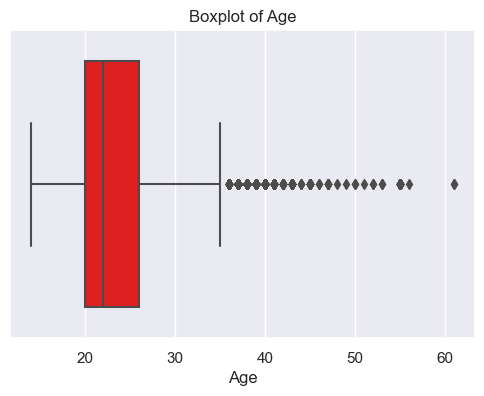

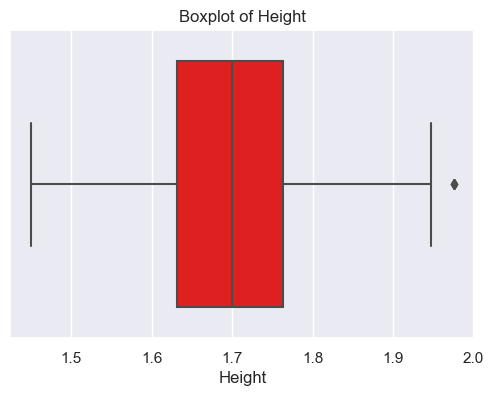

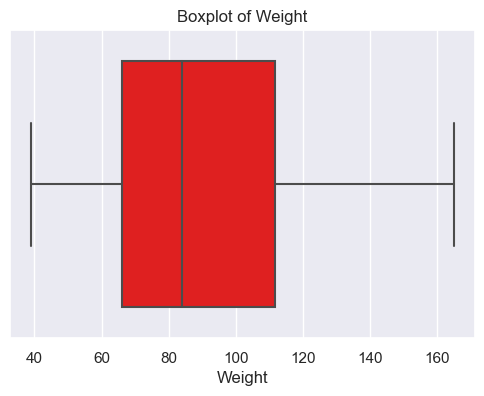

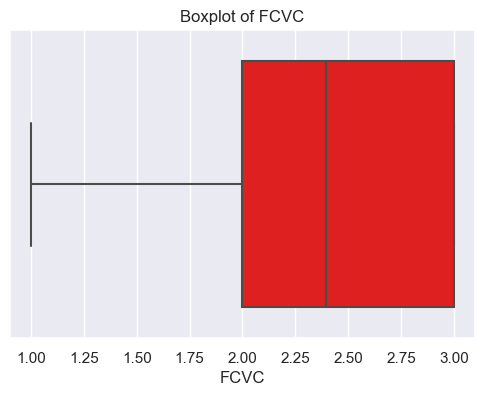

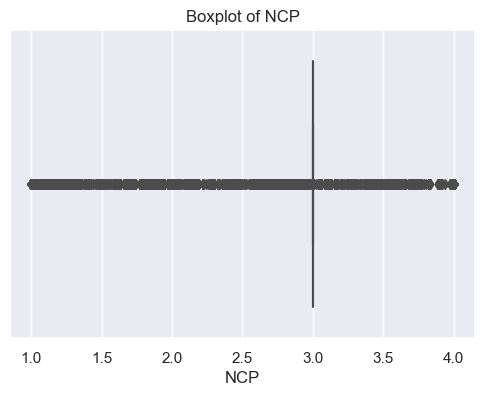

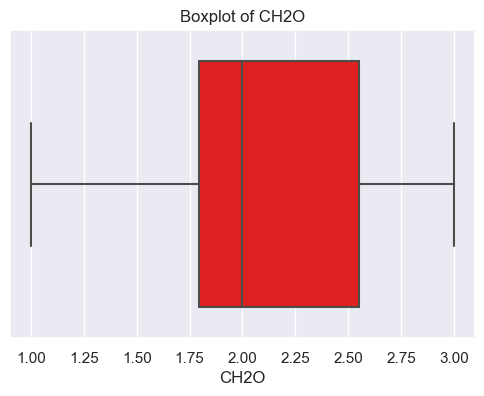

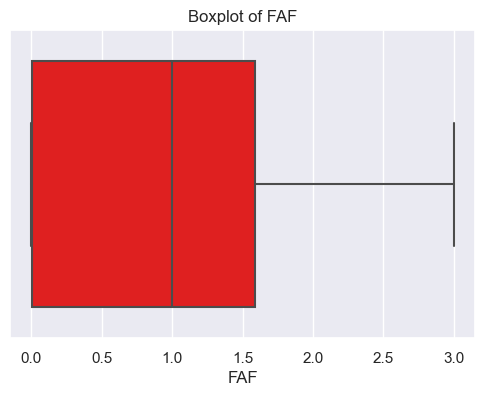

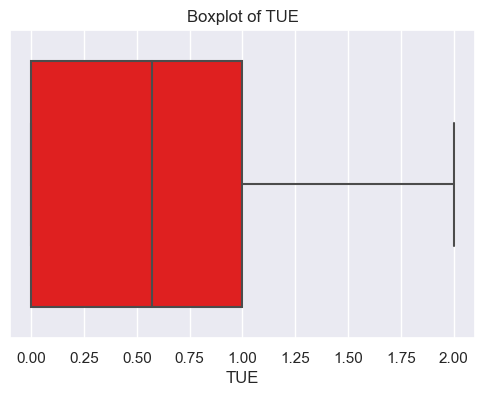

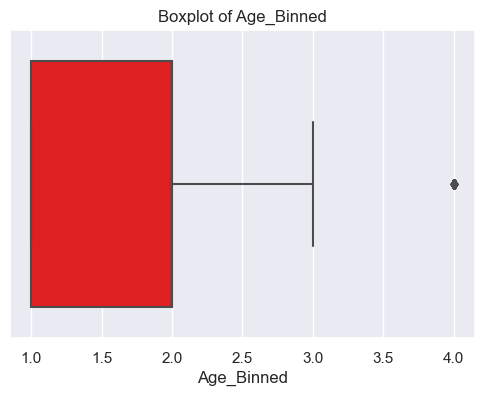

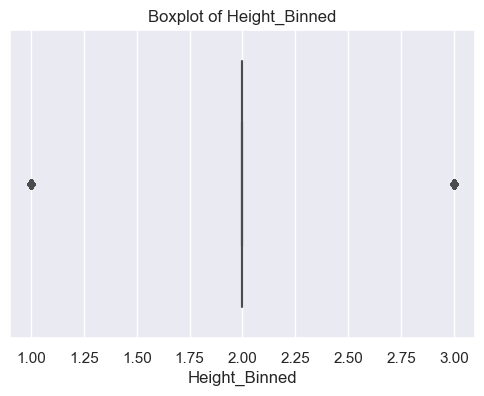

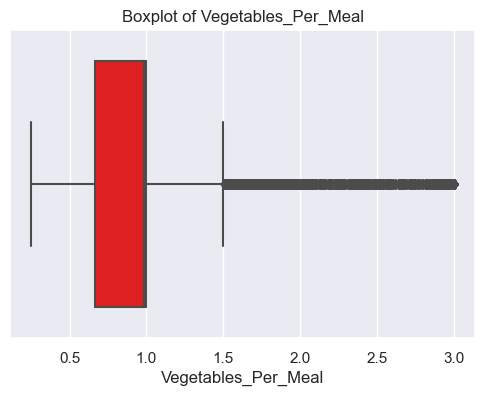

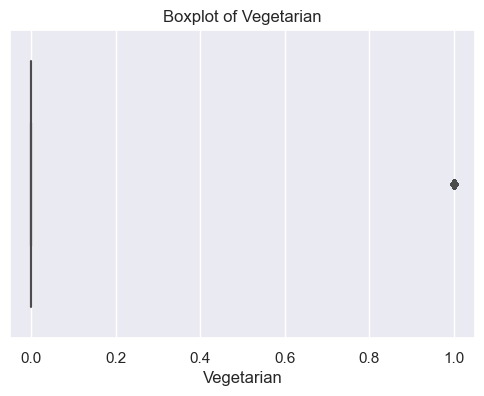

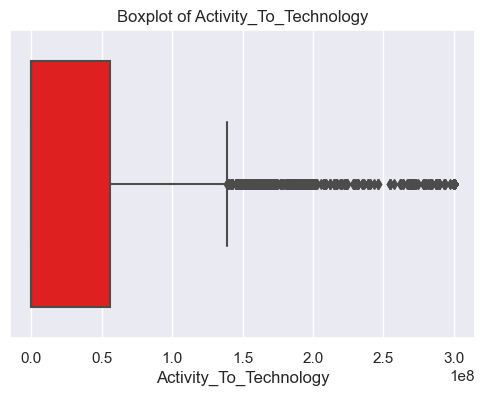

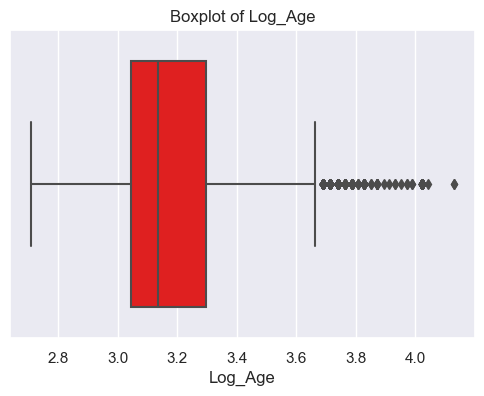

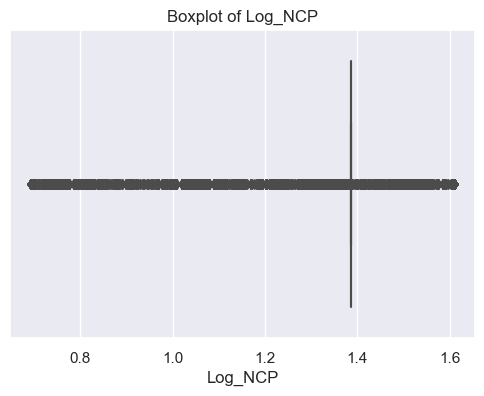

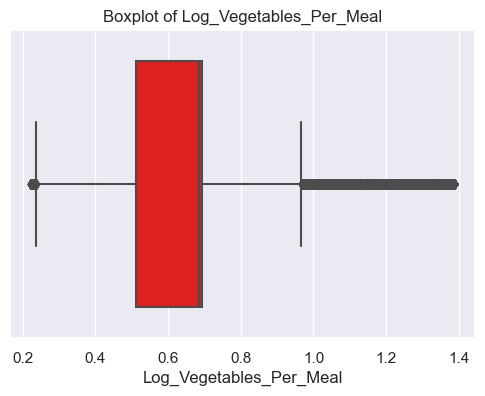

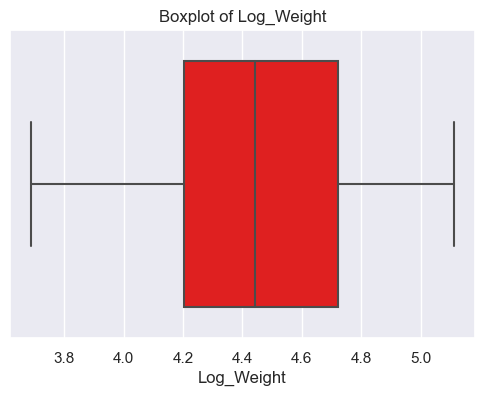

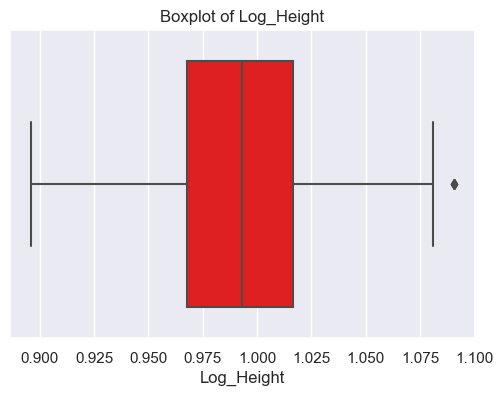

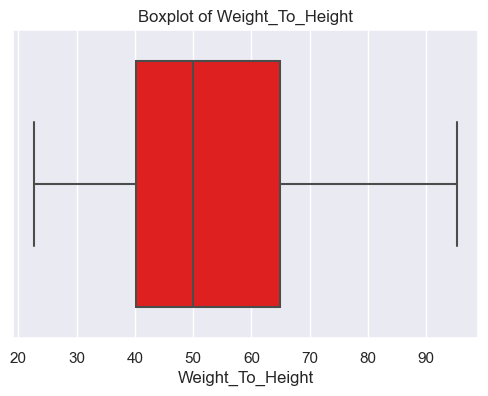

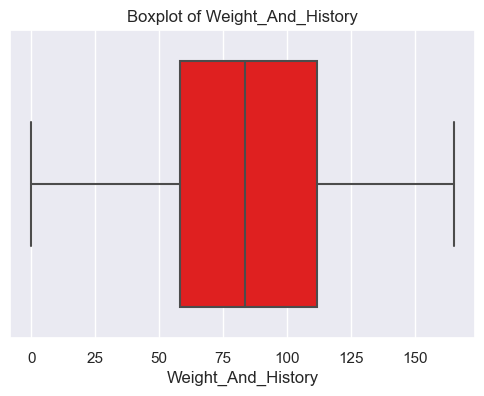

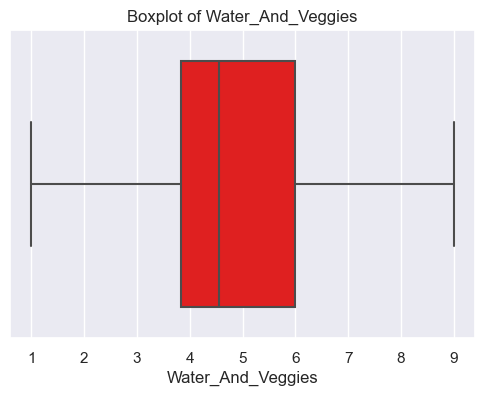

In [53]:
sns.set(style='darkgrid')
for column in final_numerical_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=column, data=train, color='red')
    plt.title(f'Boxplot of {column}')
    plt.show()

In [54]:
train.shape, test.shape

((20758, 31), (13840, 30))

# Scaling The Numerical Attributes

In [55]:
from sklearn.preprocessing import MinMaxScaler

to_be_min_max_scaled = ['Age', 'Log_Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'Vegetables_Per_Meal', 'Log_Vegetables_Per_Meal', 'Log_NCP', 'Log_Weight', 'Log_Height', 'Weight_To_Height', 'Weight_And_History', 'Water_And_Veggies']

min_max_scaler = MinMaxScaler()
train[to_be_min_max_scaled] = min_max_scaler.fit_transform(train[to_be_min_max_scaled])
test[to_be_min_max_scaled] = min_max_scaler.transform(test[to_be_min_max_scaled])

train['Activity_To_Technology'] = np.log1p(train['Activity_To_Technology'])
test['Activity_To_Technology'] = np.log1p(test['Activity_To_Technology'])

The following cell is just mapping the CALC_Always category into Frequently, because the training set does not have the 'Always' category

In [56]:
category_mapping = {'Frequently': 'Frequently', 'Sometimes': 'Sometimes', 'no': 'no', 'Always': 'Frequently'}

# Apply the mapping to both training and testing sets
train['CALC'] = train['CALC'].map(category_mapping).astype('category')
test['CALC'] = test['CALC'].map(category_mapping).astype('category')

# Categorical Encoding

I'm going to be running multiple models to then create an ensemble, which means that, although some of those models can handle categorical features on their own (CatBoostClassifier, XGBoost, LightGBM), we still need to encode the variables if we are thinking about using something like LogisticRegression or RandomForest

## One-Hot Encoding

In [57]:
train = pd.get_dummies(train, columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS'])
test = pd.get_dummies(test, columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS'])

In [58]:
train['Gender_Male'] = train['Gender_Male'].astype(np.uint8)
test['Gender_Male'] = test['Gender_Male'].astype(np.uint8)

train['Gender_Female'] = train['Gender_Female'].astype(np.uint8)
test['Gender_Female'] = test['Gender_Female'].astype(np.uint8)

In [59]:
train['family_history_with_overweight_no'] = train['family_history_with_overweight_no'].astype(np.uint8)
test['family_history_with_overweight_no'] = test['family_history_with_overweight_no'].astype(np.uint8)

train['family_history_with_overweight_yes'] = train['family_history_with_overweight_yes'].astype(np.uint8)
test['family_history_with_overweight_yes'] = test['family_history_with_overweight_yes'].astype(np.uint8)

In [60]:
train['FAVC_no'] = train['FAVC_no'].astype(np.uint8)
test['FAVC_no'] = test['FAVC_no'].astype(np.uint8)

train['FAVC_yes'] = train['FAVC_yes'].astype(np.uint8)
test['FAVC_yes'] = test['FAVC_yes'].astype(np.uint8)

In [61]:
train['CAEC_Sometimes'] = train['CAEC_Sometimes'].astype(np.uint8)
test['CAEC_Sometimes'] = test['CAEC_Sometimes'].astype(np.uint8)

train['CAEC_Frequently'] = train['CAEC_Frequently'].astype(np.uint8)
test['CAEC_Frequently'] = test['CAEC_Frequently'].astype(np.uint8)

train['CAEC_no'] = train['CAEC_no'].astype(np.uint8)
test['CAEC_no'] = test['CAEC_no'].astype(np.uint8)

train['CAEC_Always'] = train['CAEC_Always'].astype(np.uint8)
test['CAEC_Always'] = test['CAEC_Always'].astype(np.uint8)

In [62]:
train['SMOKE_no'] = train['SMOKE_no'].astype(np.uint8)
test['SMOKE_no'] = test['SMOKE_no'].astype(np.uint8)

train['SMOKE_yes'] = train['SMOKE_yes'].astype(np.uint8)
test['SMOKE_yes'] = test['SMOKE_yes'].astype(np.uint8)

In [63]:
train['SCC_no'] = train['SCC_no'].astype(np.uint8)
test['SCC_no'] = test['SCC_no'].astype(np.uint8)

train['SCC_yes'] = train['SCC_yes'].astype(np.uint8)
test['SCC_yes'] = test['SCC_yes'].astype(np.uint8)

In [64]:
train['CALC_Sometimes'] = train['CALC_Sometimes'].astype(np.uint8)
test['CALC_Sometimes'] = test['CALC_Sometimes'].astype(np.uint8)

train['CALC_no'] = train['CALC_no'].astype(np.uint8)
test['CALC_no'] = test['CALC_no'].astype(np.uint8)

train['CALC_Frequently'] = train['CALC_Frequently'].astype(np.uint8)
test['CALC_Frequently'] = test['CALC_Frequently'].astype(np.uint8)

In [65]:
train['MTRANS_Public_Transportation'] = train['MTRANS_Public_Transportation'].astype(np.uint8)
test['MTRANS_Public_Transportation'] = test['MTRANS_Public_Transportation'].astype(np.uint8)

train['MTRANS_Automobile'] = train['MTRANS_Automobile'].astype(np.uint8)
test['MTRANS_Automobile'] = test['MTRANS_Automobile'].astype(np.uint8)

train['MTRANS_Walking'] = train['MTRANS_Walking'].astype(np.uint8)
test['MTRANS_Walking'] = test['MTRANS_Walking'].astype(np.uint8)

train['MTRANS_Motorbike'] = train['MTRANS_Motorbike'].astype(np.uint8)
test['MTRANS_Motorbike'] = test['MTRANS_Motorbike'].astype(np.uint8)

train['MTRANS_Bike'] = train['MTRANS_Bike'].astype(np.uint8)
test['MTRANS_Bike'] = test['MTRANS_Bike'].astype(np.uint8)

In [66]:
train.shape, test.shape

((20758, 45), (13840, 44))

# Split Into Features and Target

In [67]:
X = train.drop(['id', 'NObeyesdad'], axis=1)
y = train.pop('NObeyesdad')

# Compute the Class Weights

In [68]:
classes = np.unique(y)
weights = compute_class_weight('balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
class_weights = {0.0: 1.1753581337410113,
 1.0: 0.962176694168907,
 2.0: 1.019047619047619,
 3.0: 0.9130014074595355,
 4.0: 0.7329284655038486,
 5.0: 1.2218494319854023,
 6.0: 1.1758241758241759}
# class_weights = {float(key): value for key, value in class_weights.items()}
class_weights

{0.0: 1.1753581337410113,
 1.0: 0.962176694168907,
 2.0: 1.019047619047619,
 3.0: 0.9130014074595355,
 4.0: 0.7329284655038486,
 5.0: 1.2218494319854023,
 6.0: 1.1758241758241759}

In [69]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [71]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
y_encoded = ordinal_encoder.fit_transform(y.values.reshape(-1, 1)).flatten()
y_encoded

array([6., 1., 0., ..., 3., 6., 3.])

# Logistic Regression

In [70]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
y_encoded = ordinal_encoder.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2)

logistic_model = LogisticRegression(
    multi_class='multinomial',
    penalty='l2',
    C=70.0,
    max_iter=10000,
    class_weight=class_weights,
    solver='newton-cg'
)

# logistic_model.fit(X_train, y_train)

# y_pred = logistic_model.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# print(f'Accuracy Score: ', accuracy)

# y_prob = logistic_model.predict_proba(X_val)

# auc_score = roc_auc_score(y_val, y_prob, multi_class='ovr', average='weighted')
# print(f'AUC Score: ', auc_score)

Accuracy Score:  0.8689788053949904
AUC Score:  0.9823145131518157


In [71]:
# params_grid = {
#     'multi_class' : ['multinomial'],
#     'penalty' : ['l2'],
#     'C' : [70],
#     'max_iter' : [10000],
#     'class_weight' : [class_weights],
#     'solver' : ['sag', 'lbfgs', 'newton-cg']
# }

# logistic_model = LogisticRegression()

# grid_search = GridSearchCV(estimator=logistic_model, param_grid=params_grid, cv=5, scoring='roc_auc_ovr_weighted')
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# print(f'Best Parameters: ', best_params)
# best_estimator = grid_search.best_estimator_
# print(f'Best Estimator: ', best_estimator)

# y_pred = best_estimator.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# print(f'Accuracy Score_ ', accuracy)

# y_prob = best_estimator.predict_proba(X_val)

# auc_score = roc_auc_score(y_val, y_prob, multi_class='ovr', average='weighted')
# print(f'AUC Score: ', auc_score)

# XGBoost Classifier

In [72]:
# from xgboost import XGBClassifier
# from sklearn.preprocessing import OrdinalEncoder

# y_encoded = OrdinalEncoder().fit_transform(y.values.reshape(-1, 1)).flatten()

# X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2)

# params_xgb = {
#     'learning_rate' : [0.015],
#     'n_estimators' : [1100],
#     'max_depth' : [6],
#     'num_class' : [7],
#     'objective' : ['multi:softmax'],
#     'min_child_weight' : [10],
#     'gamma' : [0.1],
#     'subsample' : [0.7],
#     'colsample_bytree' : [0.3],
#     'reg_alpha' : [0.005],
#     'reg_lambda' : [0.1]
# }

# xgb_model = XGBClassifier()

# grid_search = GridSearchCV(xgb_model, param_grid=params_xgb, cv=10, scoring='roc_auc_ovr_weighted', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# print(f'Best Parameters: ', best_params)
# best_estimator = grid_search.best_estimator_
# print(f'Best Estimator: ', best_estimator)

# y_pred = best_estimator.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# print(f'Accuracy: ', accuracy)

# y_prob = best_estimator.predict_proba(X_val)
# auc_score = roc_auc_score(y_val, y_prob, multi_class='ovr', average='weighted')
# print(f'AUC Score: ', auc_score)

Accuracy:  0.9079961464354528
AUC Score:  0.9913385243008246


<function matplotlib.pyplot.show(close=None, block=None)>

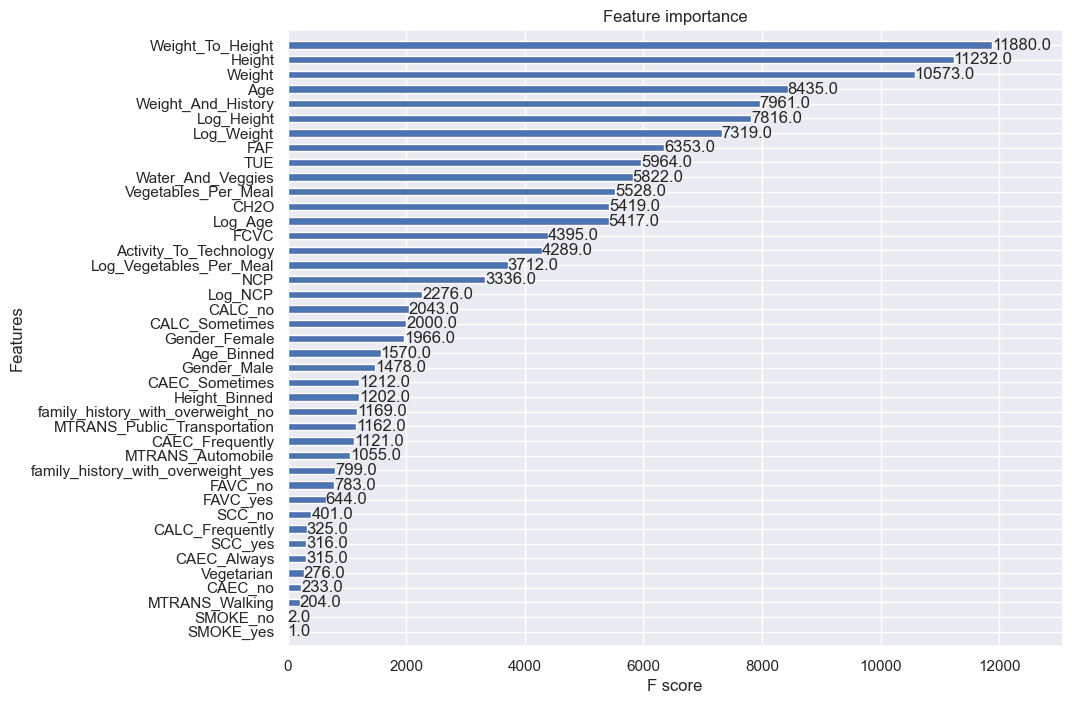

In [73]:
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import OrdinalEncoder

# y_encoded = OrdinalEncoder().fit_transform(y.values.reshape(-1, 1)).flatten()

# X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2)

params_xgb = {
    'learning_rate' : 0.015,
    'n_estimators' : 1100,
    'max_depth' : 6,
    'num_class' : 7,
    'objective' : 'multi:softmax',
    'min_child_weight' : 10,
    'gamma' : 0.1,
    'subsample' : 0.7,
    'colsample_bytree' : 0.3,
    'reg_alpha' : 0.005,
    'reg_lambda' : 0.1
}

xgb_model = XGBClassifier(**params_xgb)
# xgb_model.fit(X_train, y_train)

# y_pred = xgb_model.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# print(f'Accuracy: ', accuracy)

# y_prob = xgb_model.predict_proba(X_val)

# auc_score = roc_auc_score(y_val, y_prob, multi_class='ovr', average='weighted')
# print(f'AUC Score: ', auc_score)

# fig, ax = plt.subplots(figsize=(10, 8))
# plot_importance(xgb_model, ax=ax, importance_type='weight', height=0.5)
# plt.show

# LightGBM

In [74]:
# import lightgbm as lgb
# from lightgbm import LGBMClassifier

# y_encoded_lgb = OrdinalEncoder().fit_transform(y.values.reshape(-1, 1)).flatten()

# X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(X, y_encoded, test_size=0.2)

# params_lgb= {
#     'learning_rate' : [0.01],
#     'n_estimators' : [1000],
#     'max_depth' : [14],
#     'num_leaves' : [15],
#     'min_child_samples' : [250],
#     'feature_fraction' : [0.35],
#     'min_samples_leaf' : [85],
#     'subsample' : [0.05],
#     'is_unbalance' : [True],
#     'lambda_l2' : [0.001, 0.01, 0.1, 1, 10]
# }

# lgb_model = LGBMClassifier(objective='multiclass', num_class=7, metric='multi_logloss', boosting_type='gbdt', class_weight='balanced')
# grid_search = GridSearchCV(lgb_model, param_grid=params_lgb, scoring='roc_auc_ovr_weighted', cv=10, n_jobs=6)

# grid_search.fit(X_train_lgb, y_train_lgb)

# best_params = grid_search.best_params_
# print(f'Best Params: ', best_params)

# best_estimator = grid_search.best_estimator_
# print(f'Best Estimator: ', best_estimator)

# y_pred = best_estimator.predict(X_val_lgb)

# accuracy= accuracy_score(y_val_lgb, y_pred)
# print(f'Accuracy: ', accuracy)

# y_prob = best_estimator.predict_proba(X_val_lgb)

# auc_score = roc_auc_score(y_val_lgb, y_prob, multi_class='ovr', average='weighted')
# print(f'AUC Score: ', auc_score)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4180
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 43
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
Accuracy:  0.9070327552986512
AUC Score:  0.9902928753403285


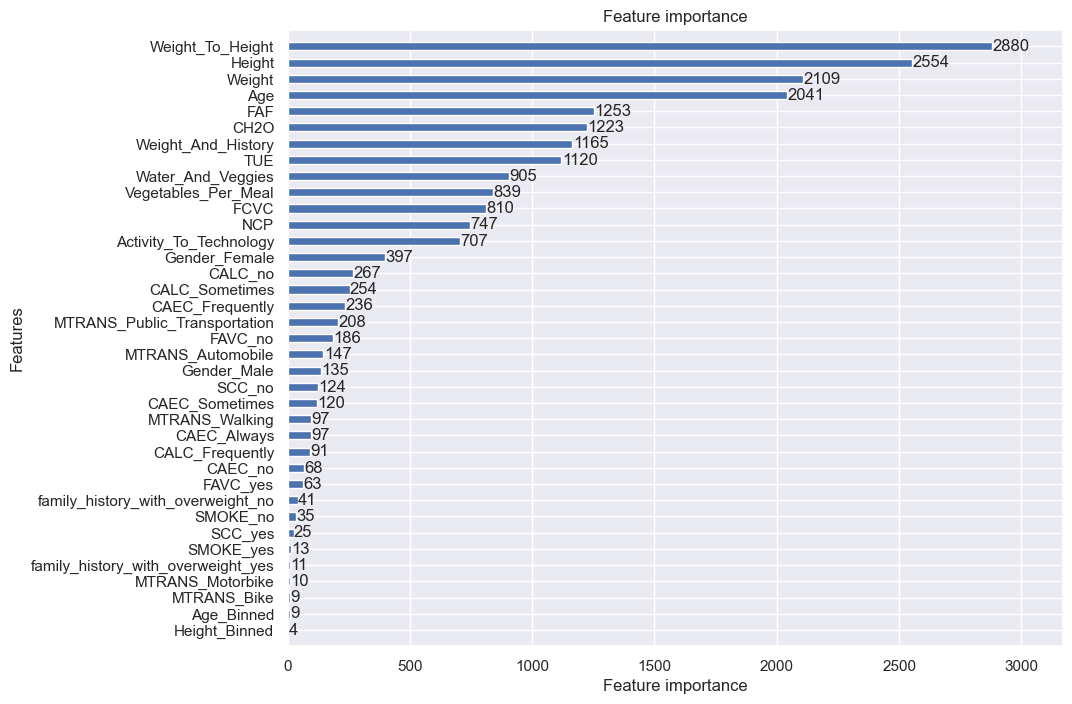

In [75]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

# y_encoded = OrdinalEncoder().fit_transform(y.values.reshape(-1, 1)).flatten()

#X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(X, y_encoded, test_size=0.2)

params_lgb= {
    'learning_rate' : 0.01,
    'n_estimators' : 1000,
    'max_depth' : 14,
    'num_leaves' : 15,
    'min_child_samples' : 250,
    'feature_fraction' : 0.35,
    'min_samples_leaf' : 85,
    'subsample' : 0.05,
    'is_unbalance' : True,
    'lambda_l2' : 10
}

lgb_model = LGBMClassifier(objective='multiclass', num_class=7, metric='multi_logloss', boosting_type='gbdt', class_weight='balanced')

# lgb_model.fit(X_train, y_train)

# y_pred = lgb_model.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# print(f'Accuracy: ', accuracy)

# y_prob = lgb_model.predict_proba(X_val)

# auc_score = roc_auc_score(y_val, y_prob, multi_class='ovr', average='weighted')
# print(f'AUC Score: ', auc_score)

# fig, ax = plt.subplots(figsize=(10, 8))
# lgb.plot_importance(lgb_model, ax=ax, importance_type='split', height=0.5)
# plt.show()

# Random Forest

In [76]:
# from sklearn.ensemble import RandomForestClassifier

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# params_rf = {
#     'n_estimators' : [1100],
#     'criterion' : ['entropy'],
#     'max_depth' : [16],
#     'min_samples_split' : [6],
#     'min_samples_leaf' : [1],
#     'max_features' : ['sqrt'],
#     'class_weight' : [class_weights]
# }

# rf_model = RandomForestClassifier()

# grid_search = GridSearchCV(rf_model, param_grid=params_rf, cv=10, n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# print(f'Best Params: ', best_params)

# best_estimator = grid_search.best_estimator_
# print(f'Best Estimator: ', best_estimator)

# y_pred = best_estimator.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# print(f'Accuracy: ', accuracy)

# y_prob = best_estimator.predict_proba(X_val)

# auc_score = roc_auc_score(y_val, y_prob, multi_class='ovr', average='weighted')
# print(f'AUC Score: ', auc_score)

In [77]:
from sklearn.ensemble import RandomForestClassifier

# y_encoded = OrdinalEncoder().fit_transform(y.values.reshape(-1, 1)).flatten()


# X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2)


params_rf = {
    'n_estimators' : 1100,
    'criterion' : 'entropy',
    'max_depth' : 16,
    'min_samples_split' : 6,
    'min_samples_leaf' : 1,
    'max_features' : 'sqrt',
    'class_weight' : class_weights
}

rf_model = RandomForestClassifier(**params_rf)

# rf_model.fit(X_train, y_train)

# y_pred = rf_model.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# print(f'Accuracy: ', accuracy)

# y_prob = rf_model.predict_proba(X_val)

# auc_score = roc_auc_score(y_val, y_prob, multi_class='ovr', average='weighted')
# print(f'AUC Score: ', auc_score)

Accuracy:  0.8983622350674374
AUC Score:  0.9895942079201062


In [78]:
from sklearn.ensemble import StackingClassifier

base_models = [
    ('RandomForest', rf_model),
    ('LogisticRegression', logistic_model),
    ('XGBoost', xgb_model)
]

meta_learner = lgb_model

stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_learner)

stacking_classifier.fit(X_train, y_train)

y_pred = stacking_classifier.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: ', accuracy)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 21
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy:  0.9036608863198459


In [79]:
from sklearn.ensemble import VotingClassifier

# X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2)

voting_classifier = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgbm', lgb_model),
        ('logreg', logistic_model),
    ],
    voting='soft'
)

voting_classifier.fit(X_train, y_train)

y_pred = voting_classifier.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: ', accuracy)

# y_prob = voting_classifier.predict_proba(X_val)

# auc_score = roc_auc_score(y_val, y_prob, multi_class='ovr', average='weighted')
# print(f'AUC Score: ', auc_score)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4179
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 43
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
Accuracy:  0.9058285163776493


In [80]:
test_noid = test.drop('id', axis=1)

In [84]:
predictions = stacking_classifier.predict(test_noid)
predicted_classes_original = ordinal_encoder.inverse_transform(np.array([predictions]).reshape(-1, 1))
predicted_classes_original

array([['Obesity_Type_II'],
       ['Overweight_Level_I'],
       ['Obesity_Type_III'],
       ...,
       ['Insufficient_Weight'],
       ['Normal_Weight'],
       ['Obesity_Type_II']], dtype=object)

In [85]:
# predictions = voting_classifier.predict(test_noid)


predicted_classes = np.ravel(predicted_classes_original)

submission = pd.DataFrame({
    'id': test.id,
    'NObeyesdad' : predicted_classes
})

submission.to_csv('submission.csv', index=False)

submission.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [86]:
download_link = f'<a href="submission.csv" download>Click here to download the submission file</a>'
from IPython.display import HTML
HTML(download_link)